In [4]:
import pandas as pd
import sqlalchemy
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [116]:
query='''
SELECT CAST(th.[TranDate] AS DATE) AS Date,p.[StockCode],p.[Class],p.[Category],p.[Collection],c.[Category] AS mode,
tl.[UnitRateBase] AS Unit_Price,
p.[Weight] AS weights, p.[OuterCtnQty], p.[CtnCbm] 
--,tl.[Quantity],tl.[ImpactAmount],tl.[LineTotalCost] AS Cost
  FROM [PowerBI].[dbo].[TransactionLine] tl
  LEFT JOIN [PowerBI].[dbo].[Product] p ON p.[ProductId]= tl.[ProductId]
  LEFT JOIN [PowerBI].[dbo].[Subsidiary] s ON s.[SubsidiaryId]=tl.[SubsidiaryId]
  LEFT JOIN [PowerBI].[dbo].[TransactionHeader] th ON th.[TransactionId] = tl.[TransactionId]
  LEFT JOIN [PowerBI].[dbo].[Customer] c ON c.[CustomerId]=th.[Entity]
  
  WHERE s.[SubsidiaryId] IN (1,3)
  AND p.[status] IN ('Current','B2C') AND tl.[TransactionType] IN ('Invoice', 'Cash Sale') AND tl.[GlId]=54
  AND tl.[UnitRateBase]<>0 
'''

In [117]:
engine=sqlalchemy.create_engine("mssql://@192.168.35.102/PowerBi?driver=SQL Server")
connection=engine.connect()
result=connection.execute(sqlalchemy.text(query))

data=[row for row in result]
connection.close()

df=pd.DataFrame(data)
df.head()

,Date,StockCode,Class,Category,Collection,mode,Unit_Price,weights,OuterCtnQty,CtnCbm
0,2019-01-02,TY4799,Osprey,Street Sports,Skates,B2C,27.09000000,2.3900,6,0.0990
1,2019-01-02,TY4799,Osprey,Street Sports,Skates,B2C,22.58000000,2.3900,6,0.0990
2,2019-01-04,BGG1324B-M,Osprey,Street Sports,Street Sports Accessories,B2C,5.97000000,0.2500,24,0.0500
3,2019-04-04,BGG1324B-M,Osprey,Street Sports,Street Sports Accessories,B2C,7.08000000,0.2500,24,0.0500
4,2019-07-25,WS0632,Osprey,Watersports,Wetsuits,B2C,32.83000000,0.7400,6,0.0420


In [118]:
# Convert 'Date' to datetime if it's not already
df["Date"] = pd.to_datetime(df["Date"])

# Now extract year, month, and day
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["Week"]=df["Date"].dt.isocalendar().week

In [119]:
df.sort_values(by="Date", ascending=True, inplace=True)

In [120]:
columns_to_encode = ['StockCode', 'Class', 'Category', 'Collection','mode']

# Apply Label Encoding
label_encoders = {}
for column in columns_to_encode:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le
    

In [121]:
df.fillna(0, inplace=True)
df=df.drop("Date", axis=1)

for col in df.columns:
    df[col]=pd.to_numeric(df[col],errors="coerce", downcast='float')



In [136]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

X = df.drop(columns=["Unit_Price"])
y = df["Unit_Price"]


scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))


idx=int(len(X)*0.85)

X_train, X_test=X_scaled[:idx], X_scaled[idx:]
y_train, y_test=y_scaled[:idx].ravel(), y_scaled[idx:].ravel()


model = RandomForestRegressor(n_estimators=100, random_state=40)
scores=cross_val_score(model, X_train,y_train.ravel(), cv=3)
model.fit(X_train, y_train.ravel())

y_pred = model.predict(X_test)

# Invert scaling to get actual values
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)
print(mae,r2)

7.02195705026387 0.903803909360061


In [ ]:
import tqdm
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

#hyperparameter tunning
hyperparameters={
    'RandomForestRegressor':{
        'n_estimators':[150,200,250],
        'max_depth':[5,10,20, None]
    },
    'GradientBoostingRegressor': {
        'n_estimators':[50,100,150],
        'learning_rate':[0.01,0.1,0.2],
        'max_depth':[3,5,7]
    },
    'XGBRegressor':{
        'n_estimators':[50,100,150],
        'learning_rate':[0.01,0.1,0.2],
        'max_depth':[3,5,7]
    },
    'SVR':{
        'C':[0.1,1,10],
        'gamma':['scale', 'auto']
    }
    
}

models = {
    'RandomForestRegressor': RandomForestRegressor(n_estimators=150, random_state=40, max_depth=5),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=50,random_state=40, max_depth=3),
    'XGBRegressor': XGBRegressor(n_estimators=50,random_state=40, max_depth=3),
    'SVR': SVR(C=0.1, gamma='scale')
}


def tune_model(model, parmas, X_train, y_train, cv=4):
    grid=GridSearchCV(model, parmas,cv=cv, scoring='neg_mean_squared_error')
    grid.fit(X_train, y_train)
    return grid.best_estimator_, -grid.best_score_

best_models={}
for name in hyperparameters.keys():
    print(f"Tuning {name}...")
    model_to_tune=models[name]
    params=hyperparameters[name]
    best_model, best_score=tune_model(model_to_tune, params, X_train, y_train)
    best_models[name]=best_model
    print(f"Best {name}: {best_model}")
    print(f"Best Score (MSE): {best_score}")

Tuning RandomForestRegressor...
Best RandomForestRegressor: RandomForestRegressor(n_estimators=150, random_state=40)
Best Score (MSE): 0.06917221352162436
Tuning GradientBoostingRegressor...
Best GradientBoostingRegressor: GradientBoostingRegressor(max_depth=7, n_estimators=50, random_state=40)
Best Score (MSE): 0.0638031363070739
Tuning XGBRegressor...
Best XGBRegressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
         

In [ ]:
''''
best models
RandomForestRegressor(n_estimators=150, random_state=40)
Best GradientBoostingRegressor: GradientBoostingRegressor(max_depth=7, n_estimators=50, random_state=40)
Best XGBRegressor: XGBRegressor( learning_rate=0.1, max_depth=7,random_state=40)

''''

In [137]:
X_test_original = scaler_x.inverse_transform(X_test)


# Get the 'Month' column (assuming it's the last column, adjust index as necessary)
#months = X_test_original[:, -1]  # Adjust the index to match the position of 'Month'

# Flatten y_test_original and y_pred_original for easy plotting
y_test_flattened = y_test_original.flatten()
y_pred_flattened = y_pred_original.flatten()

print(y_pred_flattened, y_test_flattened)

[165.8872552   27.03162279  44.12960093 ...  67.73000418  23.19439973
  13.28080089] [166.66      27.49      41.24     ...  51.42      24.989998  23.33    ]


In [138]:
X_test2=pd.DataFrame(X_test_original, columns=X.columns)

for column in columns_to_encode:
    X_test2[column]=X_test2[column].astype(int)
    X_test2[column] = label_encoders[column].inverse_transform(X_test2[column])
    

X_test2["y"]=y_test_flattened
X_test2["y_pred"]=y_pred_flattened

X_test2["Date"]=pd.to_datetime(X_test2[["Year", "Month", "Day"]])
X_test2

,StockCode,Class,Category,Collection,mode,weights,OuterCtnQty,CtnCbm,Year,Month,Day,Week,y,y_pred,Date
0,BW65350,Bestway,Watersports,Boards,B2C,13.43,1.0,0.106,2023.0,6.0,27.0,26.0,166.660004,165.887255,2023-06-27
1,SU4046,Osprey,Watersports,Watersports Accessories,B2C,0.70,12.0,0.081,2023.0,6.0,27.0,26.0,27.490000,27.031623,2023-06-27
2,WS1045,Osprey,Watersports,Wetsuits,B2C,0.84,6.0,0.043,2023.0,6.0,27.0,26.0,41.240002,44.129601,2023-06-27
3,WS0443,Osprey,Watersports,Wetsuit Accessories,B2C,0.77,12.0,0.069,2023.0,6.0,27.0,26.0,23.330000,29.353700,2023-06-27
4,BW6714NGB-1,Bestway,Airbeds,Indoor Airbeds,B2C,3.95,1.0,0.029,2023.0,6.0,27.0,26.0,49.990002,49.990002,2023-06-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192830,WS0653,Osprey,Watersports,Wetsuits,B2C,1.05,6.0,0.058,2024.0,2.0,19.0,8.0,58.330002,63.116303,2024-02-19
192831,BW60322,Lay-Z-Spa,Hot Tubs,Hot Tub Accessories,Direct Dispatch,0.85,4.0,0.025,2024.0,2.0,19.0,8.0,18.680000,25.997174,2024-02-19
192832,BGG1675,Yello,Beach Goods,Beach Accessories,Direct Dispatch,10.50,1.0,0.093,2024.0,2.0,19.0,8.0,51.419998,67.730004,2024-02-19
192833,WS0945,Osprey,Watersports,Wetsuits,B2C,0.82,6.0,0.042,2024.0,2.0,19.0,8.0,24.989998,23.194400,2024-02-19


In [139]:
X_train_original=scaler_x.inverse_transform(X_train)
y_train_original = scaler_y.inverse_transform(y_train.reshape(-1,1))

X_train2=pd.DataFrame(X_train_original, columns=X.columns)
for column in columns_to_encode:
    X_train2[column]=X_train2[column].astype(int)
    X_train2[column] = label_encoders[column].inverse_transform(X_train2[column])
    
y_train_flattened=y_train_original.flatten()
X_train2["y"]=y_train_flattened

X_train2["Date"]=pd.to_datetime(X_train2[["Year", "Month", "Day"]])
X_train2

,StockCode,Class,Category,Collection,mode,weights,OuterCtnQty,CtnCbm,Year,Month,Day,Week,y,Date
0,TY4799,Osprey,Street Sports,Skates,B2C,2.390000,6.0,0.099,2019.0,1.0,2.0,1.0,27.090000,2019-01-02
1,BW58419,Bestway,Pools,Pool Accessories,Domestic,0.340000,12.0,0.042,2019.0,1.0,2.0,1.0,9.089999,2019-01-02
2,WS0197,Osprey,Watersports,Wetsuits,Domestic,0.300000,6.0,0.016,2019.0,1.0,2.0,1.0,10.270003,2019-01-02
3,WS0463,Osprey,Watersports,Wetsuit Accessories,B2C,0.140000,24.0,0.038,2019.0,1.0,2.0,1.0,14.999999,2019-01-02
4,TY4797,Osprey,Street Sports,Skates,Domestic,2.400000,6.0,0.099,2019.0,1.0,2.0,1.0,15.189998,2019-01-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092722,WS1097,Osprey,Watersports,Wetsuits,B2C,1.360000,6.0,0.072,2023.0,6.0,27.0,26.0,58.330002,2023-06-27
1092723,TY6343,Xootz,Street Sports,Skateboards,Domestic,1.100000,8.0,0.038,2023.0,6.0,27.0,26.0,4.919999,2023-06-27
1092724,FW351-13,Osprey,Watersports,Wetsuit Accessories,B2C,0.290000,24.0,0.074,2023.0,6.0,27.0,26.0,6.990001,2023-06-27
1092725,WS0336,Osprey,Watersports,Wetsuits,B2C,0.560000,6.0,0.028,2023.0,6.0,27.0,26.0,31.490000,2023-06-27


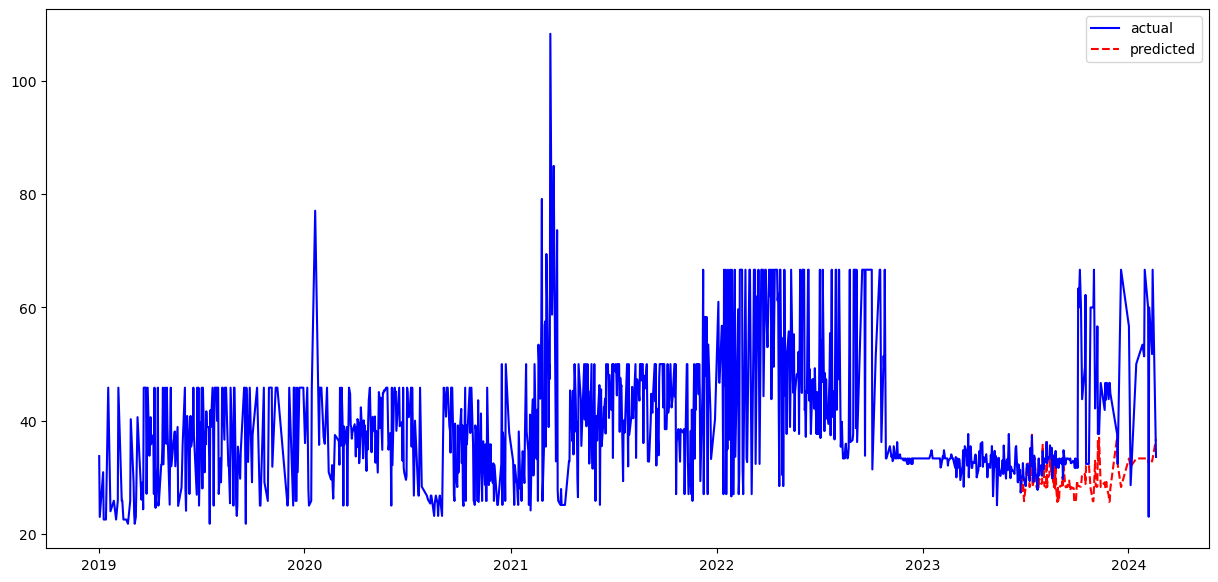

In [171]:
b=X_train2[(X_train2["StockCode"]=="BW13222")]
b_day=b.groupby("Date")[["y"]].mean()
b_day.sort_values(by="Date", ascending=True)

b_pred=X_test2[(X_test2["StockCode"]=="BW13222")]
b_pred_day=b_pred.groupby("Date")[["y_pred", "y"]].mean()

plt.figure(figsize=(15,7))
plt.plot( b_day["y"], label="actual", color='blue')
plt.plot(b_pred_day["y_pred"], linestyle="--", label='predicted',color='red')
plt.plot(b_pred_day["y"],color='blue')

plt.legend()
plt.show()



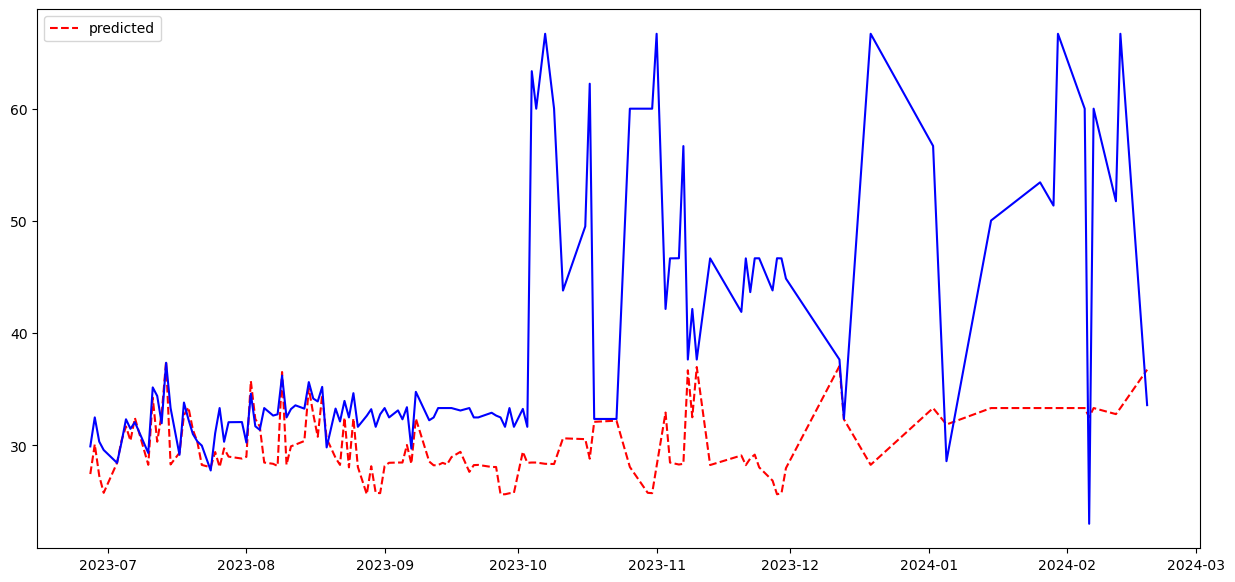

In [172]:
plt.figure(figsize=(15,7))
plt.plot(b_pred_day["y_pred"], linestyle="--", label='predicted', color='Red')
plt.plot(b_pred_day["y"], color='blue')

plt.legend()
plt.show()